In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_squared_log_error

In [2]:
#loading dataset
submission = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv')
train_data = pd.read_csv('../input/bike-sharing-demand/train.csv')
test_data = pd.read_csv('../input/bike-sharing-demand/test.csv')

In [3]:
print('Train Shape: ', train_data.shape)
print('Test Shape: ', test_data.shape)

Train Shape:  (10886, 12)
Test Shape:  (6493, 9)


In [4]:
train_data.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1138,2011-03-12 02:00:00,1,0,0,1,9.84,11.365,65,12.9980,0,14,14
8882,2012-08-12 11:00:00,3,0,0,1,30.34,33.335,42,11.0014,167,282,449
5740,2012-01-14 08:00:00,1,0,0,1,4.92,7.575,54,7.0015,3,89,92
8298,2012-07-07 03:00:00,3,0,0,1,30.34,35.605,74,8.9981,12,19,31
4298,2011-10-11 03:00:00,4,0,1,2,21.32,25.000,88,7.0015,2,1,3


In [5]:
X = train_data.iloc[:, 0:9]
Y = train_data['count']

print('Train X Shape: ', X.shape)
print('Train Y Shape: ', Y.shape)
print('Test Shape: ', test_data.shape)

Train X Shape:  (10886, 9)
Train Y Shape:  (10886,)
Test Shape:  (6493, 9)


In [6]:
#check missing value
train_data.isna().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# EDA

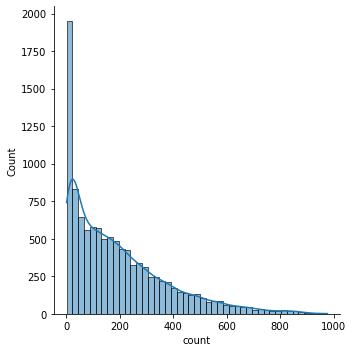

In [7]:
sns.displot(Y, kde=True)

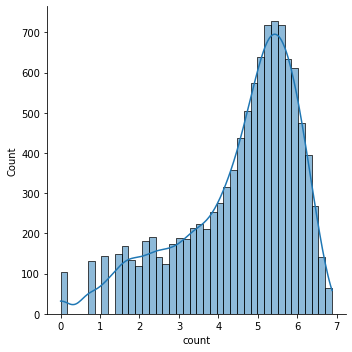

In [8]:
sns.displot(np.log(Y), kde=True)

<AxesSubplot:xlabel='season', ylabel='Count'>

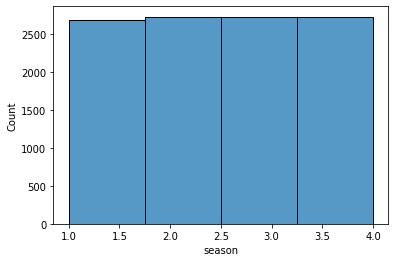

In [9]:
sns.histplot(X.season, bins=4)

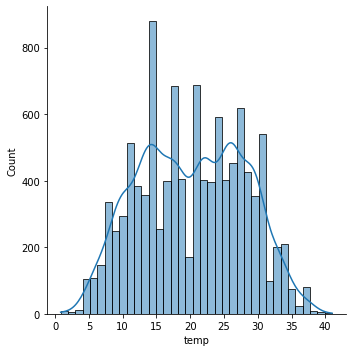

In [10]:
sns.displot(X.temp, kde=True)

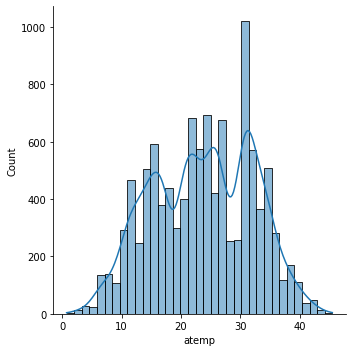

In [11]:
sns.displot(X.atemp, kde=True)

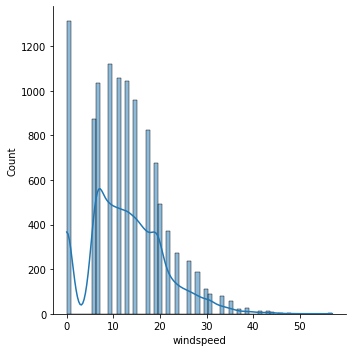

In [12]:
sns.displot(X.windspeed, kde=True)

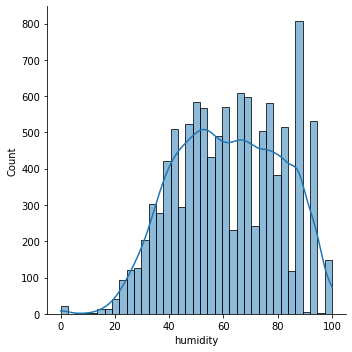

In [13]:
sns.displot(X.humidity, kde=True)

# Preprocessing & Feature Engineering with Pipeline

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import calendar
from datetime import datetime

class ProcessDateTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Transforming datetime...')
        
        x_copy = X.copy()
        x_copy['month'] = x_copy.datetime.apply(lambda x : calendar.month_name[datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday()])
        x_copy['weekday'] = x_copy.datetime.apply(lambda x : calendar.day_name[datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday()])
        x_copy['hour'] = x_copy.datetime.apply(lambda x : datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
        x_copy['minute'] = x_copy.datetime.apply(lambda x : datetime.strptime(x,"%Y-%m-%d %H:%M:%S").minute)
        x_copy = x_copy.drop(['datetime'], axis=1)
        
        return x_copy

In [15]:
pipeline = Pipeline([
    ('datetime', ProcessDateTime())
])

pipeline.fit_transform(X)

Transforming datetime...


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,weekday,hour,minute
0,1,0,0,1,9.84,14.395,81,0.0000,May,Saturday,0,0
1,1,0,0,1,9.02,13.635,80,0.0000,May,Saturday,1,0
2,1,0,0,1,9.02,13.635,80,0.0000,May,Saturday,2,0
3,1,0,0,1,9.84,14.395,75,0.0000,May,Saturday,3,0
4,1,0,0,1,9.84,14.395,75,0.0000,May,Saturday,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,February,Wednesday,19,0
10882,4,0,1,1,14.76,17.425,57,15.0013,February,Wednesday,20,0
10883,4,0,1,1,13.94,15.910,61,15.0013,February,Wednesday,21,0
10884,4,0,1,1,13.94,17.425,61,6.0032,February,Wednesday,22,0


In [16]:
class ProcessSeasonWeather(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Transforming season and weather...')
        x_copy = X.copy()
        x_copy['season'] = x_copy['season'].map({
            1: 'Spring',
            2: 'Summer',
            3: 'Fall',
            4: 'Winter'
        })
        x_copy['weather'] = x_copy['weather'].map({
            1: "Clear+FewClouds+PartlyCloudy,PartlyCloudy",
            2: "Mist+Cloudy,Mist+BrokenClouds,Mist+FewClouds,Mist",
            3: "LightSnow,LightRain+Thunderstorm+ScatteredClouds,LightRain+ScatteredClouds",
            4: "HeavyRain+IcePallets+Thunderstorm+Mist,Snow+Fog" 
        })
        return x_copy
pipeline = Pipeline([
    ('datetime', ProcessDateTime()),
    ('seasonweather', ProcessSeasonWeather())
])

In [17]:
pipeline.fit_transform(X)

Transforming datetime...
Transforming season and weather...


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,weekday,hour,minute
0,Spring,0,0,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",9.84,14.395,81,0.0000,May,Saturday,0,0
1,Spring,0,0,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",9.02,13.635,80,0.0000,May,Saturday,1,0
2,Spring,0,0,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",9.02,13.635,80,0.0000,May,Saturday,2,0
3,Spring,0,0,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",9.84,14.395,75,0.0000,May,Saturday,3,0
4,Spring,0,0,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",9.84,14.395,75,0.0000,May,Saturday,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,Winter,0,1,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",15.58,19.695,50,26.0027,February,Wednesday,19,0
10882,Winter,0,1,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",14.76,17.425,57,15.0013,February,Wednesday,20,0
10883,Winter,0,1,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",13.94,15.910,61,15.0013,February,Wednesday,21,0
10884,Winter,0,1,"Clear+FewClouds+PartlyCloudy,PartlyCloudy",13.94,17.425,61,6.0032,February,Wednesday,22,0


In [18]:
class DummyEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Dummy encoding...')
        x_copy = X.copy()
        x_copy = pd.get_dummies(x_copy)
        return x_copy

    
class RemoveFeature(BaseEstimator, TransformerMixin):
    def __init__(self, features=[]):
        self._features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Removing features...')
        x_copy = X.copy()
        for f in self._features:
            if f in x_copy.columns:
                x_copy = x_copy.drop([f], axis=1)
        return x_copy

In [19]:
pipeline = Pipeline([
    ('datetime', ProcessDateTime()),
    ('seasonweather', ProcessSeasonWeather()),
    ('dummyencode', DummyEncoding()),
    ('removefeature', RemoveFeature(features=['windspeed']))
])

In [20]:
pipeline.fit_transform(X)

Transforming datetime...
Transforming season and weather...
Dummy encoding...
Removing features...


,holiday,workingday,temp,atemp,humidity,hour,minute,season_Fall,season_Spring,season_Summer,...,month_June,month_March,month_May,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,9.84,14.395,81,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,9.02,13.635,80,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,9.02,13.635,80,2,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,9.84,14.395,75,3,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,9.84,14.395,75,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,15.58,19.695,50,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10882,0,1,14.76,17.425,57,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10883,0,1,13.94,15.910,61,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10884,0,1,13.94,17.425,61,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
pipeline = Pipeline([
    ('datetime', ProcessDateTime()),
    ('seasonweather', ProcessSeasonWeather()),
    ('dummyencode', DummyEncoding()),
    ('removefeature', RemoveFeature(features=['windspeed'])),
    ('scaler', StandardScaler())
])

In [22]:
pipeline.fit_transform(X)

Transforming datetime...
Transforming season and weather...
Dummy encoding...
Removing features...


array([[-0.17149048, -1.46067232, -1.33366069, ..., -0.40792009,
        -0.40577304, -0.40761367],
       [-0.17149048, -1.46067232, -1.43890721, ..., -0.40792009,
        -0.40577304, -0.40761367],
       [-0.17149048, -1.46067232, -1.43890721, ..., -0.40792009,
        -0.40577304, -0.40761367],
       ...,
       [-0.17149048,  0.68461625, -0.80742813, ..., -0.40792009,
        -0.40577304,  2.45330341],
       [-0.17149048,  0.68461625, -0.80742813, ..., -0.40792009,
        -0.40577304,  2.45330341],
       [-0.17149048,  0.68461625, -0.91267464, ..., -0.40792009,
        -0.40577304,  2.45330341]])

In [23]:
pipeline = Pipeline([
    ('datetime', ProcessDateTime()),
    ('seasonweather', ProcessSeasonWeather()),
    ('dummyencode', DummyEncoding()),
    ('removefeature', RemoveFeature(['windspeed'])),
    ('scaler', MinMaxScaler())
])

pipeline.fit(X)
X = pipeline.transform(X)
X_test = pipeline.transform(test_data)

Transforming datetime...
Transforming season and weather...
Dummy encoding...
Removing features...
Transforming datetime...
Transforming season and weather...
Dummy encoding...
Removing features...
Transforming datetime...
Transforming season and weather...
Dummy encoding...
Removing features...


In [24]:
print(X.shape)
print(X_test.shape)

(10886, 29)
(6493, 29)


In [25]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.224490,0.305068,0.81,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.204082,0.288064,0.80,0.043478,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.204082,0.288064,0.80,0.086957,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.224490,0.305068,0.75,0.130435,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.224490,0.305068,0.75,0.173913,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0.0,1.0,0.367347,0.423649,0.50,0.826087,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10882,0.0,1.0,0.346939,0.372860,0.57,0.869565,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10883,0.0,1.0,0.326531,0.338964,0.61,0.913043,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10884,0.0,1.0,0.326531,0.372860,0.61,0.956522,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
#Modeling
lr = LinearRegression()
sgd = SGDRegressor()
rr = Ridge()
ls = Lasso()
en = ElasticNet()

In [27]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [28]:
#crossvalidation
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=27)

grid_ridge_lasso = {
    'alpha': np.arange(0, 1, 0.05)
}

grid_elastic = {
    'alpha': np.arange(0, 1, 0.05),
    'l1_ratio': np.arange(0, 1, 0.05)
}

lr_score = cross_val_score(lr, X, np.log(Y+0.0001), cv=cv, scoring='neg_mean_squared_log_error')
sgd_score = cross_val_score(sgd, X, np.log(Y+0.0001), cv=cv, scoring='neg_mean_squared_log_error')

rr_search = GridSearchCV(rr, grid_ridge_lasso, cv=cv, scoring='neg_mean_squared_log_error')
rr_score = rr_search.fit(X, np.log(Y+0.0001))

ls_search = GridSearchCV(ls, grid_ridge_lasso, cv=cv, scoring='neg_mean_squared_log_error')
ls_score = ls_search.fit(X, np.log(Y+0.0001))

en_search = GridSearchCV(en, grid_elastic, cv=cv, scoring='neg_mean_squared_log_error')
en_score = en_search.fit(X, np.log(Y+0.0001))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5049.756067315204, tolerance: 1.9128235045682356
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site

In [29]:
print(np.mean(lr_score))
print(np.mean(sgd_score))

print(rr_score.best_score_)
print(ls_score.best_score_)
print(en_score.best_score_)

-0.13664070169138626
-0.07448596356847402
-0.07477886455495521
-0.0747767401929157
-0.0747767401929157


In [30]:
np.exp(rr_score.best_estimator_.predict(X_test))

array([ 13.37740867,  15.41881537,  17.0608271 , ..., 104.76117895,
       124.75724479, 120.63443231])

In [31]:
predictions = np.exp(rr_score.best_estimator_.predict(X_test))
predictions = predictions.astype('int')

In [32]:
predictions

array([ 13,  15,  17, ..., 104, 124, 120])

In [33]:
pd.DataFrame({
    'datetime': test_data.datetime,
    'count': predictions
})
submission.to_csv('/kaggle/working/submission.csv', index=False)